# Engineer feature variables

In [17]:
import numpy as np
import pandas as pd
import os
import pickle
from joblib import Parallel, delayed
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from ast import literal_eval

d = './raw_data/'

### Import dataset

In [18]:
with open('processed_data/clean_build.pkl', 'rb') as filename:  
    clean_data = pickle.load(filename)

In [19]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6822 entries, 0 to 6821
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     6822 non-null   object 
 1   budget                    6822 non-null   float64
 2   worldwide_boxoffice       6822 non-null   float64
 3   domestic_boxoffice        6822 non-null   float64
 4   clean_title               6822 non-null   object 
 5   imdb_id                   6812 non-null   object 
 6   release_date              6766 non-null   object 
 7   year                      6766 non-null   float64
 8   top_director              6822 non-null   object 
 9   top_cast                  6822 non-null   object 
 10  rating                    6822 non-null   float64
 11  runtime                   6822 non-null   float64
 12  original_language         6822 non-null   object 
 13  enrichment_source         6822 non-null   object 
 14  boxoffic

#### Define functions for feature engineering

In [21]:
#function to adjust for inflation, input the number and year and it will say the value adjusted for inflation to 2025
from scipy.stats import gmean

def adjust_inflation(num, year):
    diff = 2025 - year
    final_num = num * (1.0325)**diff
    return final_num
    
# def get_entry(x, entry = 'name', rank = 0):
#     if isinstance(x, list):
#         entries = [i[entry] for i in x]
#         # keep only top 3 entries
#         if len(entries) > rank:
#             out = entries[rank]
#         else:
#             out = np.nan
#         return out

#     return np.nan

def get_entry(x, rank = 0):
    if isinstance(x, list) and len(x) > rank:
        out = x[rank]
    else:
        out = np.nan
    return out

    return np.nan

def value_before_year(x, variable = "actor_id_1", category = "top_cast", value_field = "wroi", period = 5, data = clean_data):

    use_data = data.loc[(data['year'] < x['year'])*(data['year'] >= (x['year'] - period))]
    if len(use_data) > 0 and isinstance(x[variable], str):
        mask = np.array([x[variable] in entry for entry in use_data[category]]) #if variable != 'director_id' else np.array([x[variable] == entry for entry in use_data[category]])
        if np.sum(mask) > 0:
            vallist = use_data[mask]
            # Compute geometric mean
            value = gmean(vallist[value_field].values)
        else:
            value = 0
    else:
        value = 0
    return value

def appearances_before_year(x, variable = "actor_id_1", category = "top_cast", value_field = "wroi", period = 5, data = clean_data):

    use_data = data.loc[(data['year'] < x['year'])*(data['year'] >= (x['year'] - period))]
    if len(use_data) > 0 and isinstance(x[variable], str):
        mask = np.array([x[variable] in entry for entry in use_data[category]]) #if variable != 'director_id' else np.array([x[variable] == entry for entry in use_data[category]])
        if np.sum(mask) > 0:
            vallist = use_data[mask]
            # Count occurence of actor in the five year period
            value = len(vallist[value_field].values)
        else:
            value = 0
    else:
        value = 0
    return value

In [22]:
# Create adjusted revenue variables
clean_data.loc[:, 'adjusted_worldwide_boxoffice'] = adjust_inflation(clean_data['worldwide_boxoffice'], clean_data['year'])
clean_data.loc[:, 'adjusted_domestic_boxoffice'] = adjust_inflation(clean_data['domestic_boxoffice'], clean_data['year'])
clean_data.loc[:, 'adjusted_budget'] = adjust_inflation(clean_data['budget'], clean_data['year'])
clean_data.loc[:,'wroi'] = clean_data['adjusted_worldwide_boxoffice']/clean_data['adjusted_budget']
clean_data.loc[:,'droi'] = clean_data['adjusted_domestic_boxoffice']/clean_data['adjusted_budget']

# Split string variables
for i in np.arange(0,3):
    clean_data.loc[:, 'director_name_'+str(i + 1)] = clean_data['top_director'].apply(literal_eval).apply(get_entry, args = ([i]))
    clean_data.loc[:, 'director_id_'+str(i + 1)] = clean_data['top_director_id'].apply(literal_eval).apply(get_entry, args = ([i]))
    clean_data.loc[:, 'actor_name_'+str(i + 1)] = clean_data['top_cast'].apply(literal_eval).apply(get_entry, args = ([i]))
    clean_data.loc[:, 'actor_id_'+str(i + 1)] = clean_data['top_cast_id'].apply(literal_eval).apply(get_entry, args = ([i]))
    clean_data.loc[:, 'genre_name_'+str(i + 1)] = clean_data['genres_list'].apply(literal_eval).apply(get_entry, args = ([i]))
    clean_data.loc[:, 'production_country_'+str(i + 1)] = clean_data['top_production_countries'].apply(literal_eval).apply(get_entry, args = ([i]))
    clean_data.loc[:, 'production_company_'+str(i + 1)] = clean_data['top_production_companies'].apply(literal_eval).apply(get_entry, args = ([i]))

# Praneed insert code for other features here #
clean_data.loc[:,'is_language_english'] = (clean_data['original_language'] == "English")*1
clean_data.loc[:,'is_production_usa'] = 1*((clean_data['production_country_1'] == "United States of America") + (clean_data['production_country_2'] == "United States of America") + (clean_data['production_country_3'] == "United States of America") > 0) 
df= clean_data.copy()
for col in ['adjusted_budget', 'adjusted_domestic_boxoffice', 'adjusted_worldwide_boxoffice']:
        if col in df.columns and df[col].notna().any():
            Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
            IQR = Q3 - Q1
            df[f'{col}_outlier'] = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).astype(int)

if 'runtime' in df.columns:
        df['runtime_outlier'] = ((df['runtime'] < 30) | (df['runtime'] > 240)).astype(int)

clean_data= df.copy()

#### Check that variable values make sense

In [23]:
# Look for outliers
clean_data.describe().T

,count,mean,std,min,25%,50%,75%,max
budget,6822.0,3.331012e+07,4.357117e+07,1.000000,6.000000e+06,1.800000e+07,4.000000e+07,4.000000e+08
worldwide_boxoffice,6822.0,9.664417e+07,1.853715e+08,30.000000,7.566388e+06,3.121148e+07,1.008509e+08,2.748243e+09
domestic_boxoffice,6822.0,4.361615e+07,7.142061e+07,0.000000,3.233793e+06,1.884661e+07,5.289710e+07,9.366622e+08
year,6766.0,2.003467e+03,1.428892e+01,1915.000000,1.998000e+03,2.006000e+03,2.013000e+03,2.025000e+03
rating,6822.0,6.440879e+00,8.733453e-01,1.000000,5.900000e+00,6.500000e+00,7.000000e+00,1.000000e+01
runtime,6822.0,1.087986e+02,2.150746e+01,4.000000,9.500000e+01,1.050000e+02,1.190000e+02,3.390000e+02
boxoffice_corrected,6822.0,3.107593e-02,1.735357e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
is_drama,6822.0,4.777191e-01,4.995399e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
is_comedy,6822.0,3.601583e-01,4.800813e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
is_action,6822.0,2.531516e-01,4.348489e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


In [24]:
# Inspect the movies with highest ROI
clean_data.sort_values(by ="wroi", ascending=False)[['title','budget', 'worldwide_boxoffice', 'year','release_date', 'wroi']]

,title,budget,worldwide_boxoffice,year,release_date,wroi
1705,Every Which Way But Loose,5.0,106000000.0,1978.0,1978-12-19,2.120000e+07
816,Boy,3.0,43551154.0,2010.0,2010-02-14,1.451705e+07
2951,Less Than Zero,1.0,12396383.0,1987.0,1987-11-06,1.239638e+07
3368,Modern Times,1.0,8500000.0,1936.0,1936-02-05,8.500000e+06
3054,Lost & Found,1.0,6545360.0,1999.0,1999-04-23,6.545360e+06
...,...,...,...,...,...,...
5686,The Molly Maguires,11000000.0,2200000.0,NaN,NaN,NaN
5738,The Nutcracker,19000000.0,2119994.0,NaN,NaN,NaN
5868,The Reef,10000000.0,15037867.0,NaN,NaN,NaN
6250,Tracker,6500000.0,3149.0,NaN,NaN,NaN


Text(0, 0.5, 'Adjusted world boxoffice')

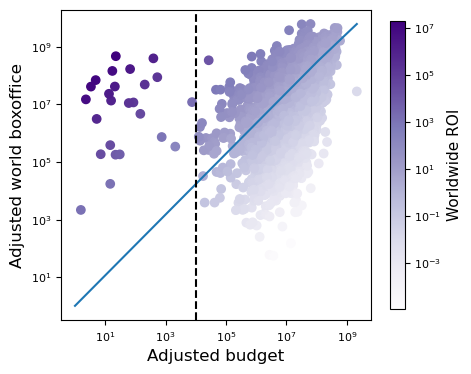

In [25]:
# Check for outliers in ROI
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

im = axs.scatter(clean_data['adjusted_budget'], clean_data['adjusted_worldwide_boxoffice'], 
            c = clean_data['wroi'], cmap = "Purples", norm = mpl.colors.LogNorm())
axs.plot(np.linspace(1, np.amax(clean_data['adjusted_budget']), 20),
         np.linspace(1, np.amax(clean_data['adjusted_worldwide_boxoffice']), 20))
axs.axvline(x = 10000, color = 'k', linestyle = "--")
plt.semilogx()
plt.semilogy()

axs.minorticks_off()
axs.set_box_aspect(1)
axs.tick_params(axis='both', which='major', labelsize=8)

cb = fig.colorbar(im, ax=axs, orientation='vertical', shrink = 0.75, pad = 0.05)
cb.set_label("Worldwide ROI", fontsize = 11)
cb.ax.tick_params(labelsize=8)
axs.set_xlabel("Adjusted budget", fontsize = 12)
axs.set_ylabel("Adjusted world boxoffice", fontsize = 12)

This motivates setting the budget cutoff at $10000

Text(0, 0.5, 'Adjusted world boxoffice')

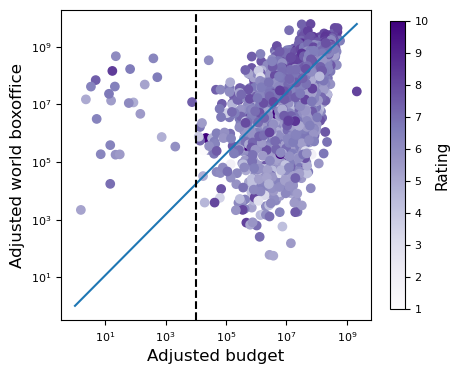

In [9]:
# Check for outliers in ratings
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

im = axs.scatter(clean_data['adjusted_budget'], clean_data['adjusted_worldwide_boxoffice'], 
            c = clean_data['rating'], cmap = "Purples", norm = mpl.colors.Normalize())
axs.plot(np.linspace(1, np.amax(clean_data['adjusted_budget']), 20),
         np.linspace(1, np.amax(clean_data['adjusted_worldwide_boxoffice']), 20))
axs.axvline(x = 10000, color = 'k', linestyle = "--")
plt.semilogx()
plt.semilogy()

axs.minorticks_off()
axs.set_box_aspect(1)
axs.tick_params(axis='both', which='major', labelsize=8)

cb = fig.colorbar(im, ax=axs, orientation='vertical', shrink = 0.75, pad = 0.05)
cb.set_label("Rating", fontsize = 11)
cb.ax.tick_params(labelsize=8)
axs.set_xlabel("Adjusted budget", fontsize = 12)
axs.set_ylabel("Adjusted world boxoffice", fontsize = 12)

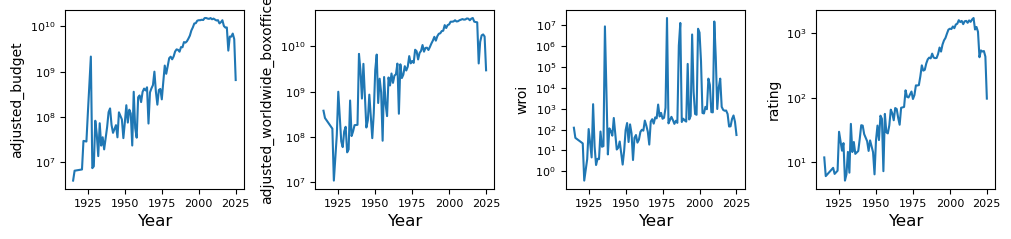

In [10]:
# Inspect distribution of observables
fig, axs = plt.subplots(1, 4, figsize=(3*4, 3), sharex=False, sharey=False)

for i, var in enumerate(['adjusted_budget', 'adjusted_worldwide_boxoffice', 'wroi', 'rating']):
    input_data = clean_data[['year'] + [var]].groupby(['year'], as_index = False).sum()
    axs[i].plot(input_data['year'], input_data[var]);
    axs[i].semilogy()
    axs[i].minorticks_off()
    axs[i].yaxis.set_tick_params(labelbottom=True)
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis='both', which='major', labelsize=8)
    axs[i].set_box_aspect(1)
    axs[i].set_ylabel(var, fontsize = 10)
    axs[i].set_xlabel('Year', fontsize = 12)

fig.subplots_adjust(wspace=.4, hspace=.35)

       year  title
0    1915.0      2
1    1921.0      1
2    1922.0      1
3    1924.0      1
4    1925.0      4
..      ...    ...
96   2021.0     67
97   2022.0     67
98   2023.0     72
99   2024.0     58
100  2025.0     13

[101 rows x 2 columns]


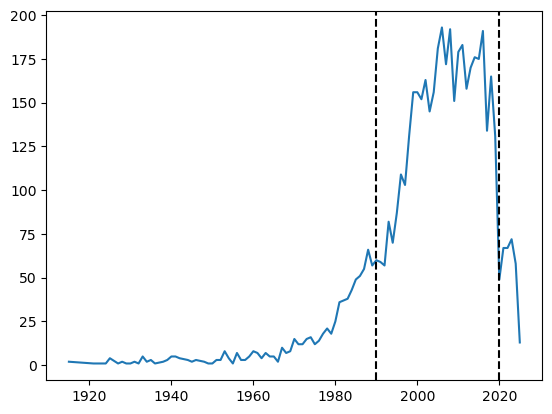

In [11]:
input_data = clean_data.loc[(clean_data.adjusted_budget >= 10000)*(clean_data.is_production_usa > 0)].groupby(['year'], as_index = False).count()
plt.plot(input_data.year, input_data.title)
plt.axvline(x = 1990, color = 'k', linestyle = "--")
plt.axvline(x = 2020, color = 'k', linestyle = "--")
print(input_data[['year', 'title']])

In [26]:
input_data = clean_data.loc[(clean_data.adjusted_budget >= 10000)*(clean_data.is_production_usa > 0)]
input_data.loc[:, 'count_appear'] = input_data.apply(appearances_before_year, args = (["production_company_2", "top_production_companies", 'wroi', 5, input_data]), axis = 1)

C:\Users\divya\AppData\Local\Temp\ipykernel_13984\869248481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[:, 'count_appear'] = input_data.apply(appearances_before_year, args = (["production_company_2", "top_production_companies", 'wroi', 5, input_data]), axis = 1)


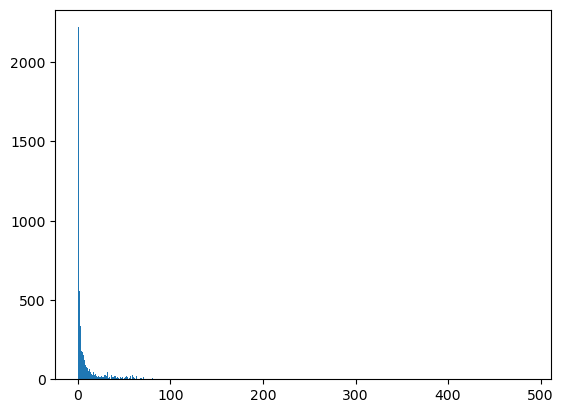

In [27]:
plt.hist(input_data.loc[:, 'count_appear'],
         bins=np.arange(0, np.amax(input_data['count_appear'])));

In [28]:
input_data[['title','budget', 'worldwide_boxoffice', 'year','release_date', 'wroi', 'top_production_companies', 'production_company_1','production_company_2','count_appear']].sort_values(by ="count_appear", ascending=False)

,title,budget,worldwide_boxoffice,year,release_date,wroi,top_production_companies,production_company_1,production_company_2,count_appear
301,Amigo,1500000.0,184705.0,2011.0,2011-08-19,0.123137,"[""Anarchist's Convention Films"", 'Pictures']",Anarchist's Convention Films,Pictures,488
3637,Oblivion,120000000.0,286168572.0,2013.0,2013-04-10,2.384738,"['Universal Pictures', 'Relativity Media', 'Mo...",Universal Pictures,Relativity Media,84
1919,Free Birds,55000000.0,110387072.0,2013.0,2013-10-30,2.007038,"['Reel FX Creative Studios', 'Relativity Media']",Reel FX Creative Studios,Relativity Media,84
38,21 and Over,13000000.0,42195766.0,2013.0,2013-03-01,3.245828,"['Mandeville Films', 'Relativity Media', 'SkyL...",Mandeville Films,Relativity Media,84
1159,Contraband,25000000.0,96262212.0,2012.0,2012-01-12,3.850488,"['Universal Pictures', 'Relativity Media', 'Wo...",Universal Pictures,Relativity Media,80
...,...,...,...,...,...,...,...,...,...,...
2190,Hands of Stone,20000000.0,5031975.0,2016.0,2016-08-26,0.251599,"['La Piedra Films', 'Fuego Films', 'Epicentral...",La Piedra Films,Fuego Films,0
2187,Hamlet 2,9000000.0,4934104.0,2008.0,2008-08-22,0.548234,['Unknown'],Unknown,NaN,0
2186,Hamlet,2000000.0,2419669.0,2000.0,2000-05-12,1.209835,"['Miramax', 'double A Films']",Miramax,double A Films,0
4631,Spun,4500000.0,1022649.0,2003.0,2003-03-14,0.227255,"['Muse Productions', 'Brink Films', 'Little Ma...",Muse Productions,Brink Films,0


In [ ]:
# Filter dataset
for_analysis = clean_data.loc[(clean_data.adjusted_budget >= 10000)*(clean_data.year >= 1990)*(clean_data.year <= 2020)*(clean_data.is_production_usa > 0)].copy()
for_analysis.describe().T

,count,mean,std,min,25%,50%,75%,max
budget,4563.0,4.143351e+07,4.814433e+07,6000.000000,1.000000e+07,2.500000e+07,5.300000e+07,4.000000e+08
worldwide_boxoffice,4563.0,1.192119e+08,2.074329e+08,30.000000,1.069153e+07,4.410398e+07,1.346261e+08,2.748243e+09
domestic_boxoffice,4563.0,5.364657e+07,7.981291e+07,0.000000,6.864016e+06,2.708770e+07,6.567951e+07,9.366622e+08
year,4563.0,2.007571e+03,8.491582e+00,1990.000000,2.001000e+03,2.008000e+03,2.014000e+03,2.025000e+03
rating,4563.0,6.389904e+00,8.293780e-01,1.900000,5.900000e+00,6.400000e+00,6.920000e+00,1.000000e+01
runtime,4563.0,1.078898e+02,1.923784e+01,13.000000,9.500000e+01,1.050000e+02,1.180000e+02,2.660000e+02
boxoffice_corrected,4563.0,1.336840e-02,1.148589e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
is_drama,4563.0,4.558405e-01,4.981007e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
is_comedy,4563.0,3.885602e-01,4.874764e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
is_action,4563.0,2.579443e-01,4.375512e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


In [16]:
# Create variables to store rolling 5-year average ROI for each category
wroi_pairs = [['director_id_1', 'top_director_id', 'wroi'], ['director_id_2', 'top_director_id', 'wroi'], ['director_id_3', 'top_director_id', 'wroi'],
         ["actor_id_1", "top_cast_id", 'wroi'],["actor_id_2", "top_cast_id", 'wroi'], ["actor_id_3", "top_cast_id", 'wroi'],
         ["genre_name_1", "genres_list", 'wroi'],["genre_name_2", "genres_list", 'wroi'], ["genre_name_3", "genres_list", 'wroi'],
         ["production_company_1", "top_production_companies", 'wroi'],["production_company_2", "top_production_companies", 'wroi'], ["production_company_3", "top_production_companies", 'wroi']]

rating_pairs = [['director_id_1', 'top_director_id', 'rating'], ['director_id_2', 'top_director_id', 'rating'], ['director_id_3', 'top_director_id', 'rating'],
         ["actor_id_1", "top_cast_id", 'rating'],["actor_id_2", "top_cast_id", 'rating'], ["actor_id_3", "top_cast_id", 'rating'],
         ["genre_name_1", "genres_list", 'rating'],["genre_name_2", "genres_list", 'rating'], ["genre_name_3", "genres_list", 'rating'],
         ["production_company_1", "top_production_companies", 'rating'],["production_company_2", "top_production_companies", 'rating'], ["production_company_3", "top_production_companies", 'rating']]

for p in wroi_pairs + rating_pairs:
    for_analysis.loc[:, 'avg_'+p[2]+'_'+p[0]] = for_analysis.apply(value_before_year, args = ([p[0], p[1], p[2], 5, for_analysis]), axis = 1)

In [9]:
for_analysis.describe().T

,count,mean,std,min,25%,50%,75%,max
budget,5274.0,3.736482e+07,4.613415e+07,6000.000000,8.500000e+06,2.000000e+07,4.800000e+07,4.000000e+08
worldwide_boxoffice,5274.0,1.097880e+08,1.968749e+08,30.000000,1.038607e+07,3.879933e+07,1.190267e+08,2.748243e+09
domestic_boxoffice,5274.0,5.123751e+07,7.646282e+07,0.000000,7.034825e+06,2.580053e+07,6.223408e+07,9.366622e+08
year,5274.0,2.003790e+03,1.286986e+01,1950.000000,1.997000e+03,2.006000e+03,2.013000e+03,2.025000e+03
rating,5274.0,6.420459e+00,8.356109e-01,1.900000,5.900000e+00,6.433000e+00,7.000000e+00,1.000000e+01
runtime,5274.0,1.083561e+02,2.015660e+01,13.000000,9.500000e+01,1.050000e+02,1.180000e+02,2.660000e+02
boxoffice_corrected,5274.0,2.502844e-02,1.562263e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
is_drama,5274.0,4.484262e-01,4.973802e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
is_comedy,5274.0,3.790292e-01,4.851914e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
is_action,5274.0,2.573000e-01,4.371875e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


In [18]:
for_analysis.sort_values(by ="wroi", ascending=False)[['title','budget', 'worldwide_boxoffice', 'year','release_date', 'wroi']]

,title,budget,worldwide_boxoffice,year,release_date,wroi
3776,Paranormal Activity,15000.0,193355800.0,2007.0,2007-09-14,12890.386667
5287,The Gallows,100000.0,42964410.0,2015.0,2015-07-09,429.644100
5011,The Blair Witch Project,600000.0,248300000.0,1999.0,1999-07-14,413.833333
4777,Super Size Me,65000.0,20645757.0,2004.0,2004-01-17,317.627031
5059,The Brothers McMullen,50000.0,10426506.0,1995.0,1995-08-09,208.530120
...,...,...,...,...,...,...
869,Broken Horses,15000000.0,3471.0,2015.0,2015-04-10,0.000231
1870,Food Chains,913000.0,176.0,2014.0,2014-11-21,0.000193
5357,The Grimm Brothers' Snow White,26000000.0,5000.0,1997.0,1997-08-24,0.000192
6091,The Walking Deceased,2000000.0,43.0,2015.0,2015-03-20,0.000022


### Export dataset

In [19]:
with open('processed_data/analysis_build.pkl', 'wb') as f:
    pickle.dump(for_analysis, f)